In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## For parametric fitting
from scipy.optimize import curve_fit


In [2]:
dtf = pd.read_csv("time_series_covid_19_confirmed.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,05-01-2021,05-02-2021
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,58542,58730,58843,59015,59225,59370,59576,59745,59939,60122
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,130270,130409,130537,130606,130736,130859,130977,131085,131185,131238
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,120562,120736,120922,121112,121344,121580,121866,122108,122311,122522
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13007,13024,13060,13083,13121,13148,13198,13232,13232,13282
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,25279,25492,25609,25710,25942,26168,26431,26652,26815,26993


In [3]:
## group by country, sum and transpose
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["India"].values, columns=["total"])
## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')
dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [5]:
dtf.tail()

,total,new
2021-04-28,18376421,379308.0
2021-04-29,18762976,386555.0
2021-04-30,19164969,401993.0
2021-05-01,19557457,392488.0
2021-05-02,19557457,0.0


In [6]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 25000*x

y_linear = f(x=np.arange(len(dtf)))
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

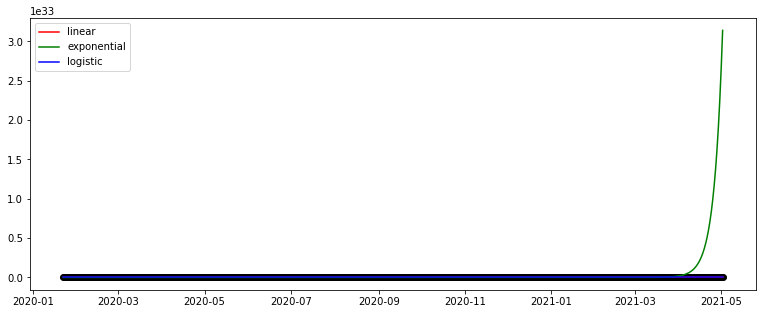

In [7]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [4]:
def f(x):
    return 6000 * np.exp(-0.5 * ((x-60)/6)**2)

y_gaussian = f(x=np.arange(len(dtf)))

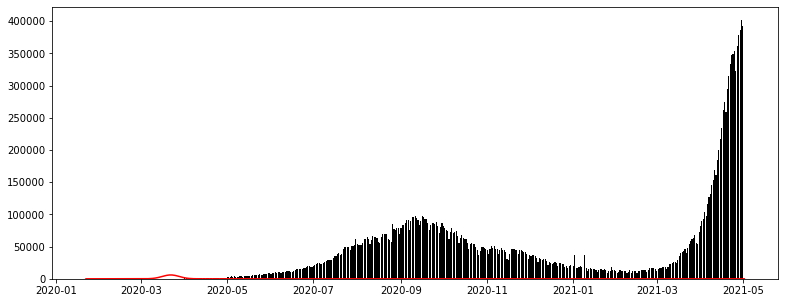

In [5]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

In [6]:
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y
## optimize from scipy
X_l=np.arange(len(dtf["total"]))
y_l=dtf["total"].values 
max_fev=500
p0_l=[np.max(dtf["total"]), 1, 1]

logistic_model, cov_l = curve_fit(logistic_f, X_l, y_l, p0_l)

In [7]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y
## optimize from scipy

X=np.arange(len(dtf["new"])) 
y=dtf["new"].values 
maxfev=500
p0=[1, np.mean(dtf["new"]), 1]
## print the parameters
gaussian_model, cov = curve_fit(gaussian_f, X, y, p0)

C:\Users\91944\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [9]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, start,  pred_ahead=60, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    dtf.reset_index(level = 0, inplace = True)
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf


In [10]:
from lmfit import model

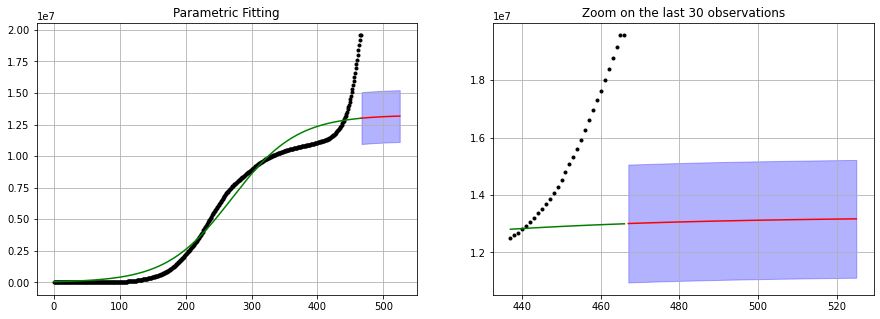

In [11]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, start='2021-12-28', pred_ahead=60, freq="D", zoom=30, figsize=(15,5))

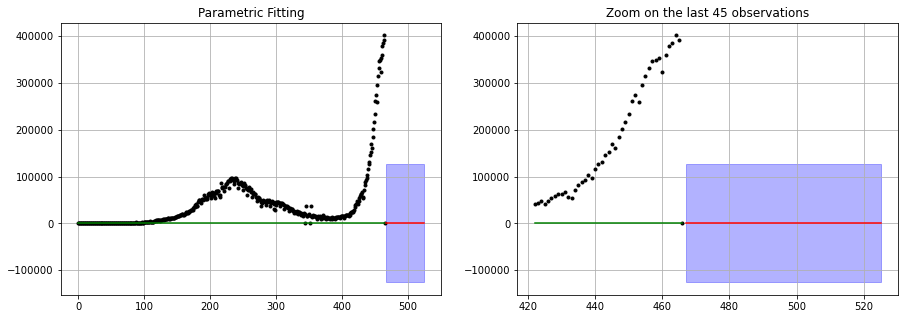

In [17]:
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, start='2021-12-28', pred_ahead=60, freq="D", zoom=45, figsize=(15,5))